In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries for data analysis,preprocessing,visualization and and machine learning tasks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.layers import Input, Dense, Layer, InputSpec
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K# Load data


In [3]:
# Load preprocessed CSV file (dataset)
user_df = pd.read_csv("/content/drive/MyDrive/yelp_academic_dataset_user_preprocessed.csv")

# Drop unnecessary columns from the user DataFrame
user_df.drop(['user_id', 'num', 'name','compliment_hot','compliment_more','compliment_profile','compliment_cute','compliment_list','compliment_note','compliment_plain','compliment_cool','compliment_funny','compliment_writer','compliment_photos'], axis=1, inplace=True)


In [4]:
user_df

,review_count,useful,funny,cool,fans,average_stars,elite_years,is_elite,years_on_platform
0,585,7217,1259,5994,267,3.91,1,1,16
1,4333,43091,13066,27281,3138,3.74,14,1,14
2,665,2086,1010,1003,52,3.32,5,1,15
3,224,512,330,299,28,4.27,3,1,18
4,79,29,15,7,1,3.54,0,0,16
...,...,...,...,...,...,...,...,...,...
1987892,23,7,0,0,0,4.92,0,0,8
1987893,1,0,0,0,0,5.00,0,0,7
1987894,4,1,1,0,0,2.00,0,0,6
1987895,2,0,0,0,0,3.00,0,0,12


# **Scaling Data**

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_df)

# **Elbow Method for Determining Optimal Clusters**

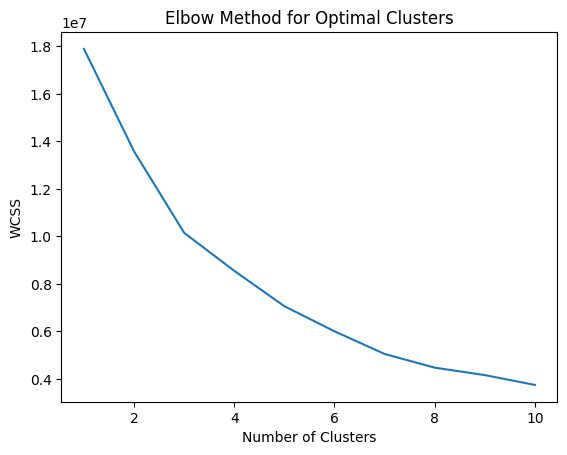

In [6]:
# Elbow Method for Optimal Clusters
def calculate_wcss(data, max_clusters=10):
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

wcss_values = calculate_wcss(scaled_data)
plt.plot(range(1, len(wcss_values) + 1), wcss_values)
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [7]:
# Choose the optimal number of clusters based on the elbow plot
optimal_clusters = 6

In [8]:
scaled_data.shape

(1987897, 9)

# **DEC (Deep Embedded Clustering) Model with ClusteringLayer**

In [9]:
# DEC Model
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform',
                                        name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

# **Encoder Architecture**

In [10]:
# Encoder
input_layer = Input(shape=(9,))
encoded = Dense(128, activation='relu',kernel_initializer = 'glorot_uniform')(input_layer)
encoded = Dense(64, activation='relu',kernel_initializer = 'glorot_uniform')(encoded)


# **Decoder Architecture**

In [11]:
# Decoder
decoded = Dense(64, activation='relu',kernel_initializer = 'glorot_uniform')(encoded)
decoded = Dense(128, activation='relu',kernel_initializer = 'glorot_uniform')(decoded)
decoded_output = Dense(9, activation='relu',kernel_initializer = 'glorot_uniform')(decoded)

# **Autoencoder Model**

In [12]:
# Autoencoder
autoencoder = Model(input_layer, decoded_output)
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(scaled_data, scaled_data, epochs=20, batch_size=128, shuffle=True)

Epoch 1/20
15531/15531 [==============================] - 70s 4ms/step - loss: 0.6240
Epoch 2/20
15531/15531 [==============================] - 64s 4ms/step - loss: 0.4042
Epoch 3/20
15531/15531 [==============================] - 62s 4ms/step - loss: 0.3171
Epoch 4/20
15531/15531 [==============================] - 63s 4ms/step - loss: 0.1969
Epoch 5/20
15531/15531 [==============================] - 62s 4ms/step - loss: 0.2054
Epoch 6/20
15531/15531 [==============================] - 64s 4ms/step - loss: 0.2010
Epoch 7/20
15531/15531 [==============================] - 62s 4ms/step - loss: 0.1804
Epoch 8/20
15531/15531 [==============================] - 61s 4ms/step - loss: 0.1847
Epoch 9/20
15531/15531 [==============================] - 63s 4ms/step - loss: 0.2042
Epoch 10/20
15531/15531 [==============================] - 63s 4ms/step - loss: 0.2009
Epoch 11/20
15531/15531 [==============================] - 63s 4ms/step - loss: 0.2073
Epoch 12/20
15531/15531 [===========================

In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 23177 (90.54 KB)
Trainable params: 23177 (90.54

In [15]:
# Define the Clustering Layer
clustering_layer = ClusteringLayer(4, name='clustering')(encoded)

# Create the DEC Model
dec_model = Model(inputs=input_layer, outputs=[decoded_output, clustering_layer])

# Compile the DEC Model
dec_model.compile(optimizer='adam', loss=['mse', 'kld'], loss_weights=[0.1, 1.0])

# Function to Update Target Distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

# Train the DEC Model
target = np.zeros((scaled_data.shape[0], 4))
dec_model.fit(scaled_data, [scaled_data, target], epochs=20, batch_size=128)

Epoch 1/20
15531/15531 [==============================] - 113s 7ms/step - loss: 0.0181 - dense_4_loss: 0.1810 - clustering_loss: -5.8933e-06
Epoch 2/20
15531/15531 [==============================] - 107s 7ms/step - loss: 0.0177 - dense_4_loss: 0.1767 - clustering_loss: -5.8933e-06
Epoch 3/20
15531/15531 [==============================] - 99s 6ms/step - loss: 0.0186 - dense_4_loss: 0.1859 - clustering_loss: -5.8933e-06
Epoch 4/20
15531/15531 [==============================] - 96s 6ms/step - loss: 0.0197 - dense_4_loss: 0.1970 - clustering_loss: -5.8933e-06
Epoch 5/20
15531/15531 [==============================] - 97s 6ms/step - loss: 0.0210 - dense_4_loss: 0.2102 - clustering_loss: -5.8933e-06
Epoch 6/20
15531/15531 [==============================] - 96s 6ms/step - loss: 0.0197 - dense_4_loss: 0.1971 - clustering_loss: -5.8933e-06
Epoch 7/20
15531/15531 [==============================] - 95s 6ms/step - loss: 0.0201 - dense_4_loss: 0.2006 - clustering_loss: -5.8933e-06
Epoch 8/20
15531/1

In [16]:
# Get cluster assignments
q, _ = dec_model.predict(scaled_data)
cluster_assignments = np.argmax(q, axis=1)

user_df['cluster'] = cluster_assignments

62122/62122 [==============================] - 135s 2ms/step


In [17]:
# Count the number of records for each cluster
cluster_counts = user_df.groupby('cluster').size().reset_index(name='count')
print(cluster_counts)

   cluster   count
0        0  465575
1        1     399
2        2     140
3        3     523
4        4    6518
5        5  757275
6        6   27475
7        7   56530
8        8  673462


# **PCA**

In [18]:
from sklearn.decomposition import PCA

q, _ = dec_model.predict(scaled_data)
cluster_assignments = np.argmax(q, axis=1)

# Use PCA for dimensionality reduction on clustering layer outputs
pca = PCA(n_components=3)
prin_comp = pca.fit_transform(q)
pca_df = pd.DataFrame(data=prin_comp, columns=['pca1', 'pca2', 'pca3'])
pca_df['cluster'] = cluster_assignments
pca_df.head()

62122/62122 [==============================] - 138s 2ms/step


,pca1,pca2,pca3,cluster
0,18.856577,3.750356,8.032752,4
1,121.110176,49.106934,105.153954,4
2,9.368612,-4.653548,1.860080,0
3,4.290802,-4.014088,0.339261,7
4,0.073920,-0.091894,0.742748,8


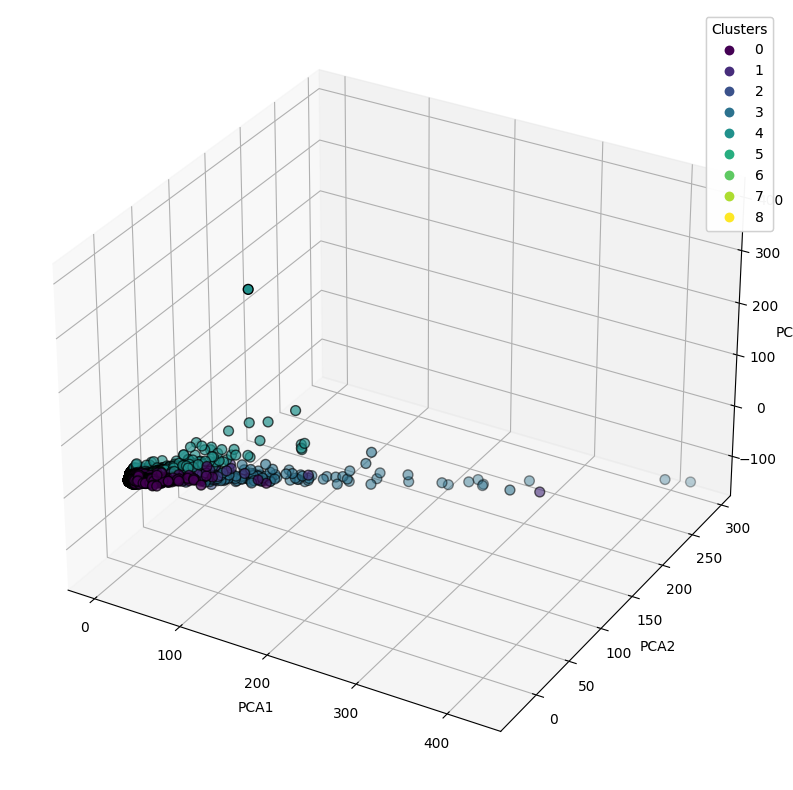

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(xs=pca_df['pca1'], ys=pca_df['pca2'], zs=pca_df['pca3'], c=pca_df['cluster'],
                     edgecolor='k', s=50)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()